## 孪生神经网络
结构如下：  
![avatar](https://images2017.cnblogs.com/blog/1055519/201801/1055519-20180124171246287-1351667928.png)


In [1]:
import torch
from torch import nn,optim
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

超参数设置

In [2]:
random.seed(78)
torch.manual_seed(78)

epoch=100
lr=0.0005
train_bs=32 
test_bs=1 # 比对样本，故bs设置为1
magrin=2.0 # 不相似样本允许最小间距
train_path='./data/faces/training'
test_path='./data/faces/testing'

数据集构建

In [3]:
train_imagefolder=ImageFolder(train_path)
test_imagefolder=ImageFolder(test_path)

class facesDataset(Dataset):
    def __init__(self,imagefolder,transform=None):
        self.imagefolder=imagefolder
        self.transform=transform

    def __getitem__(self, idx):
        sample_0=random.choice(self.imagefolder.imgs)
        get_same_class=random.randint(0,1)
        if get_same_class:
            while True:
                sample_1=random.choice(self.imagefolder.imgs)
                if sample_0[1]==sample_1[1]:
                    break
        else:
            while True:
                sample_1=random.choice(self.imagefolder.imgs)
                if sample_0[1]!=sample_1[1]:
                    break
        
        img0=Image.open(sample_0[0]).convert('L')
        img1=Image.open(sample_1[0]).convert('L')
        if self.transform is not None:
            img0=self.transform(img0)
            img1=self.transform(img1)
            
        # 相似样本标签为0 不相似样本标签为1
        return img0,img1,torch.from_numpy(np.array([int(sample_0[1]!=sample_1[1])])).float()

    def __len__(self):
        return len(self.imagefolder.imgs)

构建加载器

In [4]:
tf=transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])
train_dataset=facesDataset(train_imagefolder,transform=tf)
test_dataset=facesDataset(test_imagefolder,transform=tf)

train_Dataloader=DataLoader(train_dataset,batch_size=train_bs,shuffle=True)
test_Dataloader=DataLoader(test_dataset,batch_size=test_bs,shuffle=False)

可视化部分样例

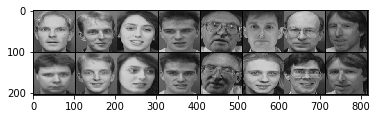

labels: tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]])


In [5]:
# 0 相似 1 不相似
dataiter=iter(train_Dataloader)
img0s,img1s,labels=dataiter.__next__()
all_imgs=torch.cat((img0s[:8],img1s[:8]),dim=0)
grid_images=make_grid(all_imgs,nrow=8)
images=grid_images.numpy().transpose(1,2,0)
plt.imshow(images)
plt.show()
print('labels:',labels[:8])

网络搭建

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 100 * 100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

构建对比损失ContrastiveLoss  
loss表达式：![avatar](https://images2017.cnblogs.com/blog/1055519/201801/1055519-20180124171726334-1380192508.png)  
式中D<sub>w</sub>是欧式距离，m是magrin。

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self,margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin=margin

    def forward(self, input1, input2, label):
        euclidean_distance=F.pairwise_distance(input1,input2,keepdim=True)
        loss_contrastive=torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [8]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=SiameseNetwork().to(device)
optimizer=optim.Adam(model.parameters(),lr=lr)
criterion=ContrastiveLoss(margin=magrin).to(device)

训练

In [9]:
train_losses = []
for e in range(epoch):
    model.train()
    total_loss=0.0
    total=0
    for i,(img0,img1,label) in enumerate(train_Dataloader):
        img0,img1,label=img0.to(device),img1.to(device),label.to(device)
        output0,output1=model(img0,img1)
        loss=criterion(output0,output1,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.cpu().item()*label.shape[0]
        total+=label.shape[0]
        train_losses.append(loss.cpu().item())
    print('epoch:{},loss:{:.4f}'.format(e,total_loss/total))

epoch:0,loss:5.7114
epoch:1,loss:1.8214
epoch:2,loss:1.4094
epoch:3,loss:0.7042
epoch:4,loss:0.5743
epoch:5,loss:0.3734
epoch:6,loss:0.3596
epoch:7,loss:0.3613
epoch:8,loss:0.2667
epoch:9,loss:0.2502
epoch:10,loss:0.1619
epoch:11,loss:0.1793
epoch:12,loss:0.1780
epoch:13,loss:0.1526
epoch:14,loss:0.1263
epoch:15,loss:0.1383
epoch:16,loss:0.1221
epoch:17,loss:0.1175
epoch:18,loss:0.1058
epoch:19,loss:0.0861
epoch:20,loss:0.0765
epoch:21,loss:0.0720
epoch:22,loss:0.0715
epoch:23,loss:0.0692
epoch:24,loss:0.0755
epoch:25,loss:0.0680
epoch:26,loss:0.0576
epoch:27,loss:0.0712
epoch:28,loss:0.0612
epoch:29,loss:0.0460
epoch:30,loss:0.0456
epoch:31,loss:0.0475
epoch:32,loss:0.0525
epoch:33,loss:0.0449
epoch:34,loss:0.0397
epoch:35,loss:0.0365
epoch:36,loss:0.0507
epoch:37,loss:0.0472
epoch:38,loss:0.0437
epoch:39,loss:0.0446
epoch:40,loss:0.0429
epoch:41,loss:0.0270
epoch:42,loss:0.0387
epoch:43,loss:0.0386
epoch:44,loss:0.0374
epoch:45,loss:0.0291
epoch:46,loss:0.0298
epoch:47,loss:0.0283
ep

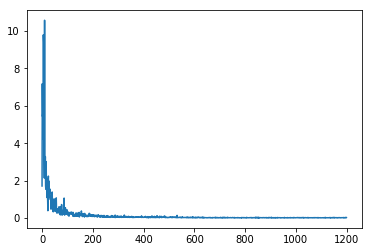

In [10]:
plt.figure()
plt.plot(train_losses)
plt.show()

测试

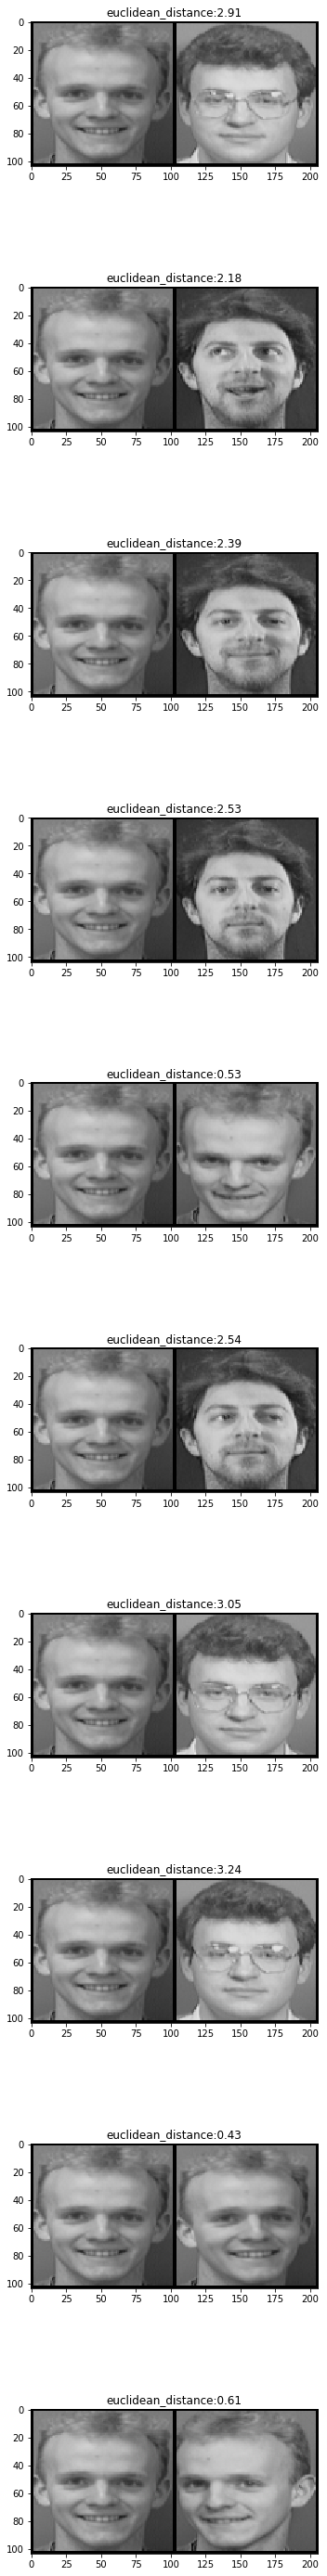

In [12]:
model.eval()
test_dataiter=iter(test_Dataloader)
x0,_,_=test_dataiter.__next__()
fig,axes=plt.subplots(10,1,figsize=(5,40))
for i in range(10):
    _,x1,_=test_dataiter.__next__()
    x0,x1=x0.to(device),x1.to(device)
    output0, output1 = model(x0, x1)
    euclidean_distance=F.pairwise_distance(output0,output1)

    output=torch.cat((x0.cpu(),x1.cpu()),dim=0)
    grid_output=make_grid(output)
    grid_numpy=grid_output.numpy().transpose(1,2,0)
    axes[i].imshow(grid_numpy)
    axes[i].set_title('euclidean_distance:{:.2f}'.format(euclidean_distance.item()))
plt.tight_layout()
plt.show()

In [13]:
torch.cuda.empty_cache()